In [1]:
import os
import math
from dataclasses import dataclass
from typing import Tuple, Optional, Literal

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

from einops import rearrange
import torch.optim as optim
import torch.utils.data as data
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

plt.set_cmap('cividis')
%matplotlib inline
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

<Figure size 640x480 with 0 Axes>

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "D:/Malky/research/data/mla_jax"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "D:/Malky/research/saved_models/mla_deepSeek_reverse"


# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


Seed set to 42


Device: cuda:0


In [3]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    # 
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            # ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            # ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

In [4]:
world_size = 1
rank = 0
block_size = 128
gemm_impl: Literal["bf16", "fp8"] = "bf16"
attn_impl: Literal["naive", "absorb"] = "naive" # naive -> train, absorb -> inference

In [5]:
@dataclass
class ModelArgs:
    """
    Data class for defining model arguments and hyperparameters.

    Attributes:
        max_batch_size (int): Maximum batch size.
        max_seq_len (int): Maximum sequence length.
        dtype (Literal["bf16", "fp8"]): Data type for computations.
        vocab_size (int): Vocabulary size.
        dim (int): Model dimension.
        inter_dim (int): Intermediate dimension for MLP layers.
        moe_inter_dim (int): Intermediate dimension for MoE layers.
        n_layers (int): Number of transformer layers.
        n_dense_layers (int): Number of dense layers in the model.
        n_heads (int): Number of attention heads.
        n_routed_experts (int): Number of routed experts for MoE layers.
        n_shared_experts (int): Number of shared experts for MoE layers.
        n_activated_experts (int): Number of activated experts in MoE layers.
        n_expert_groups (int): Number of expert groups.
        n_limited_groups (int): Number of limited groups for MoE routing.
        score_func (Literal["softmax", "sigmoid"]): Scoring function for MoE routing.
        route_scale (float): Scaling factor for routing scores.
        q_lora_rank (int): LoRA rank for query projections.
        kv_lora_rank (int): LoRA rank for key-value projections.
        qk_nope_head_dim (int): Dimension for query-key projections without positional embeddings. size of the future predictions
        qk_rope_head_dim (int): Dimension for query-key projections with rotary embeddings.
        v_head_dim (int): Dimension for value projections.
        original_seq_len (int): Original sequence length.
        rope_theta (float): Base for rotary positional encoding.
        rope_factor (float): Scaling factor for extended sequence lengths.
        beta_fast (int): Fast beta correction factor.
        beta_slow (int): Slow beta correction factor.
        mscale (float): Scaling factor for extended attention.
    """
    max_batch_size: int = 1 # 8
    max_seq_len: int = 128 # 4096 * 4
    dtype: Literal["bf16", "fp8"] = "bf16"
    vocab_size: int = 10#102400 
    dim: int = 64 #2048
    inter_dim: int = 128# 10944
    # moe_inter_dim: int = 1408
    n_layers: int = 1#27
    n_dense_layers: int = 1
    n_heads: int = 1#16
    # moe
    # n_routed_experts: int = 64
    # n_shared_experts: int = 2
    # n_activated_experts: int = 6
    # n_expert_groups: int = 1
    # n_limited_groups: int = 1
    # score_func: Literal["softmax", "sigmoid"] = "softmax"
    # route_scale: float = 1.
    # mla
    q_lora_rank: int = 0
    kv_lora_rank: int = 64 #512
    qk_nope_head_dim: int = 32# 128
    qk_rope_head_dim: int = 16# 64
    v_head_dim: int = 64 #128
    
    # yarn
    original_seq_len: int = 128 #4096
    rope_theta: float = 10000.0
    rope_factor: float = 40
    beta_fast: int = 32
    beta_slow: int = 1
    mscale: float = 1.


    input_dim:int = 2

In [7]:
def apply_rotary_emb(x: torch.Tensor, freqs_cis: torch.Tensor) -> torch.Tensor:
    """
    Applies rotary positional embeddings to the input tensor.

    Args:
        x (torch.Tensor): Input tensor with positional embeddings to be applied.
        freqs_cis (torch.Tensor): Precomputed complex exponential values for positional embeddings.

    Returns:
        torch.Tensor: Tensor with rotary embeddings applied.
    """
    dtype = x.dtype
    x = torch.view_as_complex(x.float().view(*x.shape[:-1], -1, 2))
    freqs_cis = freqs_cis.view(1, x.size(1), 1, x.size(-1))
    y = torch.view_as_real(x * freqs_cis).flatten(3)
    return y.to(dtype)



def precompute_freqs_cis(args: ModelArgs) -> torch.Tensor:
    """
    Precomputes frequency-based complex exponential values for rotary positional embeddings.

    Args:
        args (ModelArgs): Model arguments containing positional embedding parameters.

    Returns:
        torch.Tensor: Precomputed complex exponential values for positional embeddings.
    """
    dim = args.qk_rope_head_dim
    seqlen = args.max_seq_len
    beta_fast = args.beta_fast
    beta_slow = args.beta_slow
    base = args.rope_theta
    factor = args.rope_factor

    def find_correction_dim(num_rotations, dim, base, max_seq_len):
        """
        Computes the correction dimension for a given number of rotations in the rotary positional embedding.

        Args:
            num_rotations (float): Number of rotations to compute the correction for.
            dim (int): Dimensionality of the embedding space.
            base (float): Base value for the exponential computation.
            max_seq_len (int): Maximum sequence length.

        Returns:
            float: The correction dimension based on the input parameters.
        """
        return dim * math.log(max_seq_len / (num_rotations * 2 * math.pi)) / (2 * math.log(base))

    def find_correction_range(low_rot, high_rot, dim, base, max_seq_len):
        """
        Computes the range of correction dimensions for rotary positional embeddings.

        Args:
            low_rot (float): Lower bound for the number of rotations.
            high_rot (float): Upper bound for the number of rotations.
            dim (int): Dimensionality of the embedding space.
            base (float): Base value for the exponential computation.
            max_seq_len (int): Maximum sequence length.

        Returns:
            Tuple[int, int]: The range of correction dimensions (low, high), clamped to valid indices.
        """
        low = math.floor(find_correction_dim(low_rot, dim, base, max_seq_len))
        high = math.ceil(find_correction_dim(high_rot, dim, base, max_seq_len))
        return max(low, 0), min(high, dim-1)

    def linear_ramp_factor(min, max, dim):
        """
        Computes a linear ramp function used to smooth values between a minimum and maximum range.

        Args:
            min (float): Minimum value for the ramp function.
            max (float): Maximum value for the ramp function.
            dim (int): Dimensionality of the ramp tensor.

        Returns:
            torch.Tensor: A tensor of shape (dim,) with values linearly interpolated between 0 and 1,
                clamped to the range [0, 1].
        """
        if min == max:
            max += 0.001
        linear_func = (torch.arange(dim, dtype=torch.float32) - min) / (max - min)
        ramp_func = torch.clamp(linear_func, 0, 1)
        return ramp_func

    freqs = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))
    if seqlen > args.original_seq_len:
        low, high = find_correction_range(beta_fast, beta_slow, dim, base, args.original_seq_len)
        smooth = 1 - linear_ramp_factor(low, high, dim // 2)
        freqs = freqs / factor * (1 - smooth) + freqs * smooth

    t = torch.arange(seqlen)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis

Original

In [8]:
class MLAPos(nn.Module):
    """
    Multi-Headed Attention Layer (MLA).

    Attributes:
        dim (int): Dimensionality of the input features.
        n_heads (int): Number of attention heads.
        n_local_heads (int): Number of local attention heads for distributed systems.
        q_lora_rank (int): Rank for low-rank query projection.
        kv_lora_rank (int): Rank for low-rank key/value projection.
        qk_nope_head_dim (int): Dimensionality of non-positional query/key projections.
        qk_rope_head_dim (int): Dimensionality of rotary-positional query/key projections.
        qk_head_dim (int): Total dimensionality of query/key projections.
        v_head_dim (int): Dimensionality of value projections.
        softmax_scale (float): Scaling factor for softmax in attention computation.
    """
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.dim = args.dim
        self.n_heads = args.n_heads
        self.n_local_heads = args.n_heads // world_size
        self.q_lora_rank = args.q_lora_rank
        self.kv_lora_rank = args.kv_lora_rank
        self.qk_nope_head_dim = args.qk_nope_head_dim
        self.qk_rope_head_dim = args.qk_rope_head_dim
        self.qk_head_dim = args.qk_nope_head_dim + args.qk_rope_head_dim
        self.v_head_dim = args.v_head_dim

        # Query
        if self.q_lora_rank == 0:
            self.wq = torch.nn.Linear(in_features=self.dim, out_features= self.n_heads * self.qk_head_dim) # normal Query (no latent space)
        else:
            self.wq_a = torch.nn.Linear(in_features = self.dim, out_features = self.q_lora_rank)  # latent space (Q reduced )
            self.q_norm = torch.nn.RMSNorm(normalized_shape = self.q_lora_rank)
            self.wq_b = torch.nn.Linear(in_features= self.q_lora_rank, out_features=self.n_heads * self.qk_head_dim)
        
        self.wkv_a = torch.nn.Linear(in_features=self.dim, out_features=self.kv_lora_rank + self.qk_rope_head_dim)
        self.kv_norm = torch.nn.RMSNorm(normalized_shape =self.kv_lora_rank)
        self.wkv_b = torch.nn.Linear(in_features=self.kv_lora_rank, out_features=self.n_heads * (self.qk_nope_head_dim + self.v_head_dim))



        self.wo = torch.nn.Linear(in_features=self.n_heads * self.v_head_dim, out_features= self.dim)
        
        self.softmax_scale = self.qk_head_dim ** -0.5
        if args.max_seq_len > args.original_seq_len:
            mscale = 0.1 * args.mscale * math.log(args.rope_factor) + 1.0
            self.softmax_scale = self.softmax_scale * mscale * mscale

        if attn_impl == "naive":
            self.register_buffer("k_cache", torch.zeros(args.max_batch_size, args.max_seq_len, self.n_local_heads, self.qk_head_dim), persistent=False)
            self.register_buffer("v_cache", torch.zeros(args.max_batch_size, args.max_seq_len, self.n_local_heads, self.v_head_dim), persistent=False)
            
            # Init parameters
            self._reset_parameters() 
        else:
            self.register_buffer("kv_cache", torch.zeros(args.max_batch_size, args.max_seq_len, self.kv_lora_rank), persistent=False)
            self.register_buffer("pe_cache", torch.zeros(args.max_batch_size, args.max_seq_len, self.qk_rope_head_dim), persistent=False)
            
    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation

        if self.q_lora_rank == 0:
            nn.init.xavier_uniform_(self.wq.weight)
            self.wq.bias.data.fill_(0)
        else:
            nn.init.xavier_uniform_(self.wq_a.weight)
            self.wq_a.bias.data.fill_(0)

            nn.init.xavier_uniform_(self.wq_b.weight)
            self.wq_b.bias.data.fill_(0)
        
        nn.init.xavier_uniform_(self.wkv_a.weight)
        self.wkv_a.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.wkv_b.weight)
        self.wkv_b.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.wo.weight)
        self.wo.bias.data.fill_(0)

    def forward(self, x: torch.Tensor, start_pos: int, freqs_cis: torch.Tensor, mask: Optional[torch.Tensor], return_attention: bool= False):
        """
        Forward pass for the Multi-Headed Attention Layer (MLA).

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, dim).
            start_pos (int): Starting position in the sequence for caching.
            freqs_cis (torch.Tensor): Precomputed complex exponential values for rotary embeddings.
            mask (Optional[torch.Tensor]): Mask tensor to exclude certain positions from attention.

        Returns:
            torch.Tensor: Output tensor with the same shape as the input.
        """
        bsz, seqlen, _ = x.size()
        end_pos = start_pos + seqlen
        
        # Queries
        if self.q_lora_rank == 0:
            q = self.wq(x)
        
        else:
            # reduction (latent space) -> norm -> increse space 
            q = self.wq_b(self.q_norm(self.wq_a(x)))

        q = q.view(bsz, seqlen, self.n_local_heads, self.qk_head_dim) # batch, sequence lenght, number of heads, dimension
        
        q_nope, q_pe = torch.split(q, [self.qk_nope_head_dim, self.qk_rope_head_dim], dim=-1)
        q_pe = apply_rotary_emb(q_pe, freqs_cis)

        # KV -> keys , values
        kv = self.wkv_a(x) # get kv reduction
        kv, k_pe = torch.split(kv, [self.kv_lora_rank, self.qk_rope_head_dim], dim=-1)
        k_pe = apply_rotary_emb(k_pe.unsqueeze(2), freqs_cis)

        
        if attn_impl == "naive":
            q = torch.cat([q_nope, q_pe], dim=-1) # concatenate [q^C, q^R]
            kv = self.wkv_b(self.kv_norm(kv)) # increase dimension
            kv = kv.view(bsz, seqlen, self.n_local_heads, self.qk_nope_head_dim + self.v_head_dim) # batch, sequence lenght, number of heads, dimension
            k_nope, v = torch.split(kv, [self.qk_nope_head_dim, self.v_head_dim], dim=-1) # k^C, v^C
            k = torch.cat([k_nope, k_pe.expand(-1, -1, self.n_local_heads, -1)], dim=-1) # concat[k^c, k^R]
            self.k_cache[:bsz, start_pos:end_pos] = k
            self.v_cache[:bsz, start_pos:end_pos] = v
            scores = torch.einsum("bshd,bthd->bsht", q, self.k_cache[:bsz, :end_pos]) * self.softmax_scale
        else:
            wkv_b = self.wkv_b.weight
            wkv_b = wkv_b.view(self.n_local_heads, -1, self.kv_lora_rank)
            q_nope = torch.einsum("bshd,hdc->bshc", q_nope, wkv_b[:, :self.qk_nope_head_dim])
            self.kv_cache[:bsz, start_pos:end_pos] = self.kv_norm(kv)
            self.pe_cache[:bsz, start_pos:end_pos] = k_pe.squeeze(2)
            scores = (torch.einsum("bshc,btc->bsht", q_nope, self.kv_cache[:bsz, :end_pos]) +
                      torch.einsum("bshr,btr->bsht", q_pe, self.pe_cache[:bsz, :end_pos])) * self.softmax_scale
        
        if mask is not None:
            scores += mask.unsqueeze(1)
        scores = scores.softmax(dim=-1, dtype=torch.float32).type_as(x)
        
        
        if attn_impl == "naive":
            x = torch.einsum("bsht,bthd->bshd", scores, self.v_cache[:bsz, :end_pos])
        else:
            x = torch.einsum("bsht,btc->bshc", scores, self.kv_cache[:bsz, :end_pos])
            x = torch.einsum("bshc,hdc->bshd", x, wkv_b[:, -self.v_head_dim:])
   
        x = self.wo(x.flatten(2))

        if return_attention:
            return x, scores
        else:
            return x
    


edited MLA with no Rotary position

In [9]:
class MLA(nn.Module):
    """
    Multi-Headed Attention Layer (MLA).

    Attributes:
        dim (int): Dimensionality of the input features.
        n_heads (int): Number of attention heads.
        n_local_heads (int): Number of local attention heads for distributed systems.
        q_lora_rank (int): Rank for low-rank query projection.
        kv_lora_rank (int): Rank for low-rank key/value projection.
        qk_head_dim (int): Total dimensionality of query/key projections. 
        v_head_dim (int): Dimensionality of value projections.
        softmax_scale (float): Scaling factor for softmax in attention computation.
    """
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.dim = args.dim
        self.n_heads = args.n_heads
        self.n_local_heads = args.n_heads // world_size
        self.q_lora_rank = args.q_lora_rank
        self.kv_lora_rank = args.kv_lora_rank
        self.qk_head_dim = args.qk_nope_head_dim 
        self.v_head_dim = args.v_head_dim

        # Query
        if self.q_lora_rank == 0:
            self.wq = torch.nn.Linear(in_features=self.dim, out_features= self.n_heads * self.qk_head_dim) # normal Query (no latent space)
        else:
            self.wq_a = torch.nn.Linear(in_features = self.dim, out_features = self.q_lora_rank)  # latent space (Q reduced )
            self.q_norm = torch.nn.RMSNorm(normalized_shape = self.q_lora_rank)
            self.wq_b = torch.nn.Linear(in_features= self.q_lora_rank, out_features=self.n_heads * self.qk_head_dim)
        
        self.wkv_a = torch.nn.Linear(in_features=self.dim, out_features=self.kv_lora_rank)
        self.kv_norm = torch.nn.RMSNorm(normalized_shape =self.kv_lora_rank)
        self.wkv_b = torch.nn.Linear(in_features=self.kv_lora_rank, out_features=self.n_heads * (self.qk_head_dim + self.v_head_dim))



        self.wo = torch.nn.Linear(in_features=self.n_heads * self.v_head_dim, out_features= self.dim)
        
        self.softmax_scale = self.qk_head_dim ** -0.5

        if attn_impl == "naive":
            self.register_buffer("k_cache", torch.zeros(args.max_batch_size, args.max_seq_len, self.n_local_heads, self.qk_head_dim), persistent=False)
            self.register_buffer("v_cache", torch.zeros(args.max_batch_size, args.max_seq_len, self.n_local_heads, self.v_head_dim), persistent=False)
        else:
            self.register_buffer("kv_cache", torch.zeros(args.max_batch_size, args.max_seq_len, self.kv_lora_rank), persistent=False)

        # include K,Q,V
    
    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation

        if self.q_lora_rank == 0:
            nn.init.xavier_uniform_(self.wq.weight)
            self.wq.bias.data.fill_(0)
        else:
            nn.init.xavier_uniform_(self.wq_a.weight)
            self.wq_a.bias.data.fill_(0)

            nn.init.xavier_uniform_(self.wq_b.weight)
            self.wq_b.bias.data.fill_(0)
        
        nn.init.xavier_uniform_(self.wkv_a.weight)
        self.wkv_a.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.wkv_b.weight)
        self.wkv_b.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.wo.weight)
        self.wo.bias.data.fill_(0)

    def forward(self, x: torch.Tensor, start_pos: int,  mask: Optional[torch.Tensor],  return_attention: bool= False):
        """
        Forward pass for the Multi-Headed Attention Layer (MLA).

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, dim).
            start_pos (int): Starting position in the sequence for caching.
            mask (Optional[torch.Tensor]): Mask tensor to exclude certain positions from attention.

        Returns:
            torch.Tensor: Output tensor with the same shape as the input.
        """
 
        bsz, seqlen, _ = x.size()
        end_pos = start_pos + seqlen
        
        # Queries
        if self.q_lora_rank == 0:
            q = self.wq(x)
        else:
            # reduction (latent space) -> norm -> increse space 
            q = self.wq_b(self.q_norm(self.wq_a(x)))

        q = q.view(bsz, seqlen, self.n_local_heads, self.qk_head_dim) # batch, sequence lenght, number of heads, dimension
        
        # KV -> keys , values
        kv = self.wkv_a(x) # get kv reduction
       
        if attn_impl == "naive":
            kv = self.wkv_b(self.kv_norm(kv)) # increase dimension
            kv = kv.view(bsz, seqlen, self.n_local_heads, self.qk_head_dim + self.v_head_dim) # batch, sequence lenght, number of heads, dimension
     
            k, v = torch.split(kv, [self.qk_head_dim, self.v_head_dim], dim=-1) # k^C, v^C
            
            self.k_cache[:bsz, start_pos:end_pos] = k
            self.v_cache[:bsz, start_pos:end_pos] = v
            scores = torch.einsum("bshd,bthd->bsht", q, self.k_cache[:bsz, :end_pos]) * self.softmax_scale
        else:
            
            wkv_b = self.wkv_b.weight.view(self.n_local_heads, -1, self.kv_lora_rank) # n_local_heads x kv_lora x d
            # Apply LoRA transformation to queries (previously q_nope)
            q = torch.einsum("bshd,hdc->bshc", q, wkv_b[:, :self.qk_head_dim])
            
            self.kv_cache[:bsz, start_pos:end_pos] = self.kv_norm(kv)
            scores = torch.einsum("bshc,btc->bsht", q, self.kv_cache[:bsz, :end_pos]) * self.softmax_scale
        
        if mask is not None:
            scores += mask.unsqueeze(1)
        scores = scores.softmax(dim=-1, dtype=torch.float32).type_as(x) # score softmax of the scores and set the type as the same as the input x
        
        
        if attn_impl == "naive":
            x = torch.einsum("bsht,bthd->bshd", scores, self.v_cache[:bsz, :end_pos])
        else:
            x = torch.einsum("bsht,btc->bshc", scores, self.kv_cache[:bsz, :end_pos])
            x = torch.einsum("bshc,hdc->bshd", x, wkv_b[:, -self.v_head_dim:])
   
        x = self.wo(x.flatten(2))
        
       
        if return_attention:
            return x, scores
        else:
            return x

In [10]:
attn_impl= "absorb"#Literal["naive", "absorb"] = "naive" # naive -> train, absorb -> inference
args = ModelArgs()
mla = MLA(args)
batch_size = 1
seq_len = 10
x= torch.randn(batch_size, seq_len, args.dim)
output , attention = mla(x = x, start_pos =  0, mask = None, return_attention = True)

print("Output shape:", output.shape)
print("attention ", attention.shape)


Output shape: torch.Size([1, 10, 64])
attention  torch.Size([1, 10, 1, 10])


Common MLP

In [11]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) used as a feed-forward layer.

    Attributes:
        w1 (nn.Module): Linear layer for input-to-hidden transformation.
        w2 (nn.Module): Linear layer for hidden-to-output transformation.
        w3 (nn.Module): Additional linear layer for feature transformation.
    """
    def __init__(self, dim: int, inter_dim: int):
        """
        Initializes the MLP layer.

        Args:
            dim (int): Input and output dimensionality.
            inter_dim (int): Hidden layer dimensionality.
        """
        super().__init__()
        self.w1 = torch.nn.Linear(in_features=dim, out_features=inter_dim)
        self.w2 = torch.nn.Linear(in_features=inter_dim, out_features=dim)
        self.w3 = torch.nn.Linear(in_features=dim, out_features=inter_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the MLP layer.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after MLP computation.
        """
        return self.w2(F.silu(self.w1(x)) * self.w3(x)) #Output=W_2(SiLU(W_1x) ⊙ (W_3x))

test MLP

In [12]:
batch_size = 1
seq_len = 12
dim = 64

ffn = MLP(dim=64, inter_dim=128)
x = torch.randn(batch_size, seq_len, dim)
result = ffn(x)
print(result.shape)

torch.Size([1, 12, 64])


Define block with position 

In [13]:
class BlockPos(nn.Module):
    """
    Transformer block combining attention and feed-forward layers.

    Attributes:
        attn (nn.Module): Attention layer (MLA).
        ffn (nn.Module): Feed-forward network (MLP or MoE).
        attn_norm (nn.Module): Layer normalization for attention.
        ffn_norm (nn.Module): Layer normalization for feed-forward network.
    """
    def __init__(self, layer_id: int, args: ModelArgs):
        """
        Initializes the Transformer block.

        Args:
            layer_id (int): Layer index in the transformer.
            args (ModelArgs): Model arguments containing block parameters.
        """
        super().__init__()
        self.attn = MLAPos(args)
        self.ffn = MLP(args.dim, args.inter_dim) #if layer_id < args.n_dense_layers else MoE(args)
        self.attn_norm = torch.nn.RMSNorm(args.dim)
        self.ffn_norm = torch.nn.RMSNorm(args.dim)

    def forward(self, x: torch.Tensor, start_pos: int, freqs_cis: torch.Tensor, mask: Optional[torch.Tensor]) -> torch.Tensor:
        """
        Forward pass for the Transformer block.

        Args:
            x (torch.Tensor): Input tensor.
            start_pos (int): Starting position in the sequence.
            freqs_cis (torch.Tensor): Precomputed complex exponential values for rotary embeddings.
            mask (Optional[torch.Tensor]): Mask tensor to exclude certain positions from attention.

        Returns:
            torch.Tensor: Output tensor after block computation.
        """
        x = x + self.attn(self.attn_norm(x), start_pos, freqs_cis, mask)
        x = self.ffn_norm(x)
        x = x + self.ffn(x)
        return x
    

    
class TransformerPos(nn.Module):
    """
    Transformer model with positional embeddings, multiple layers, and output projection.

    Attributes:
        max_seq_len (int): Maximum sequence length for the transformer.
        embed (nn.Module): Embedding layer for input tokens.
        layers (torch.nn.ModuleList): List of transformer blocks.
        norm (nn.Module): Layer normalization applied after all blocks.
        head (nn.Module): Output projection layer mapping to vocabulary size.
        freqs_cis (torch.Tensor): Precomputed complex exponential values for rotary embeddings.
    """
    def __init__(self, args: ModelArgs):
        """
        Initializes the Transformer model.

        Args:
            args (ModelArgs): Model arguments containing transformer parameters.
        """
        super().__init__()
        self.max_seq_len = args.max_seq_len
        # self.embed = torch.nn.Linear(args.vocab_size, args.dim)

        print(self.max_seq_len, args.dim)

        self.embed = torch.nn.Linear(in_features = args.input_dim, out_features= args.dim)
        self.layers = torch.nn.ModuleList()
        for layer_id in range(args.n_layers):
            self.layers.append(BlockPos(layer_id, args))
        # self.norm = torch.nn.RMSNorm(args.dim)
        # self.head = torch.nn.Linear(args.dim, args.vocab_size, dtype=torch.get_default_dtype())
        self.register_buffer("freqs_cis", precompute_freqs_cis(args), persistent=False)


    def forward(self, tokens: torch.Tensor, mask: Optional[torch.Tensor], start_pos: int = 0):
        """
        Forward pass for the Transformer model.

        Args:
            tokens (torch.Tensor): Input tensor of token IDs with shape (batch_size, seq_len).
            start_pos (int, optional): Starting position in the sequence for rotary embeddings. Defaults to 0.

        Returns:
            torch.Tensor: Logits tensor of shape (batch_size, vocab_size).
        """

        
        seqlen = tokens.size(1)
       
        h = self.embed(tokens)
        freqs_cis = self.freqs_cis[start_pos:start_pos+seqlen]
 
    
        for layer in self.layers:
            h = layer(h, start_pos, freqs_cis, mask)

    
        # h = self.norm(h)[:, -1]
        # h = self.norm(h)
        # print("h print after norm",h.shape)
        # logits = self.head(h)

        
        # return logits

        return h
    

    def get_attention_maps(self, tokens: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        seqlen = tokens.size(1)
        h = self.embed(tokens)
        freqs_cis = self.freqs_cis[start_pos:start_pos+seqlen]

        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.attn(x=h, start_pos = start_pos, freqs_cis =freqs_cis, mask = mask, return_attention = True)
            attention_maps.append(rearrange(attn_map, "b s h d -> b h s d"))
            h = layer(h, start_pos, freqs_cis, mask)
        return attention_maps
    


ModelArgs(max_batch_size=1, max_seq_len=10, dtype='bf16', vocab_size=10, dim=64, inter_dim=128, n_layers=1, n_dense_layers=1, n_heads=1, q_lora_rank=0, kv_lora_rank=64, qk_nope_head_dim=32, qk_rope_head_dim=16, v_head_dim=64, original_seq_len=128, rope_theta=10000.0, rope_factor=40, beta_fast=32, beta_slow=1, mscale=1.0, input_dim=2)
10 64
Output shape: torch.Size([1, 10, 64])
attention  torch.Size([1, 10, 1, 10])
torch.Size([1, 1, 10, 10])


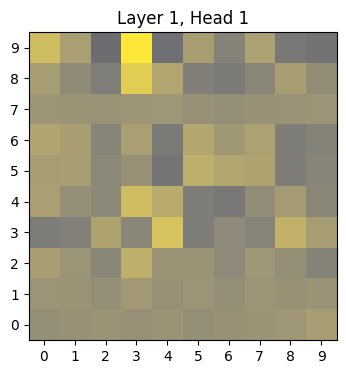

In [14]:
attn_impl= "absorb"#Literal["naive", "absorb"] = "naive" # naive -> train, absorb -> inference
args = ModelArgs()


batch_size = 1
seq_len = 10
x= torch.randn(batch_size, seq_len, 2)
args.max_seq_len = seq_len

print(args)

transpos = TransformerPos(args)
output  = transpos(tokens = x, mask = None, start_pos = 0)

print("Output shape:", output.shape)
print("attention ", attention.shape)

att = transpos.get_attention_maps(tokens = x, mask = None, start_pos = 0)
for i in att:
    print(i.shape)
plot_attention_maps(x, att, idx=0)

PyTorch Lightning Module

In [ ]:
ModelArgs(max_batch_size=128, 
          max_seq_len=128, dtype='bf16',
            vocab_size=10, 
            dim=64, 
            inter_dim=128, 
            n_layers=1, 
            n_dense_layers=1, 
            n_heads=1, 
            q_lora_rank=0, kv_lora_rank=64, qk_nope_head_dim=32, qk_rope_head_dim=16, 
          v_head_dim=64, original_seq_len=128, rope_theta=10000.0, rope_factor=40, beta_fast=32, beta_slow=1, mscale=1.0, input_dim=1

In [63]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [64]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, args):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        
        self.transformer = TransformerPos(args=args)
        self.output_net = nn.Sequential(
            nn.Linear(args.dim, args.dim),
            nn.LayerNorm(args.dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(args.dim, args.vocab_size)
        )
        self.args = args

    def forward(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        x = self.transformer(tokens = x, mask = mask, start_pos = start_pos)
        x = self.output_net(x)
        return x
    
    @torch.no_grad()
    def get_attention_maps(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        attention_maps = self.transformer.get_attention_maps(tokens = x, mask = mask, start_pos = start_pos)
        return attention_maps
    
    def configure_optimizers(self):

        optimizer = optim.Adam(self.parameters(), lr=0.001)

        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=50,
                                             max_iters=50)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]




        # #  return torch.optim.Adam(self.parameters(), lr=0.001)
        # optimizer = optim.Adam(self.parameters(), lr=0.01)
        
        # # Apply lr scheduler per step
        # warmup_epochs = 5
        # total_epochs = 50

        # warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
        # cosine_scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
        # scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])

        # return {
        #     "optimizer": optimizer,
        #     "lr_scheduler": {
        #         "scheduler": scheduler,
        #         "interval": "step"  # Adjust learning rate per step
        #     }
        # }
       
       
    
    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError
    

In [65]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

In [66]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)

In [67]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([1, 1, 5, 8, 6, 8, 1, 6, 8, 6, 3, 5, 5, 8, 9, 9])
Labels:     tensor([9, 9, 8, 5, 5, 3, 6, 8, 6, 1, 8, 6, 8, 5, 1, 1])


In [ ]:
class ReversePredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
       
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.args.vocab_size).float()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, mask=None, start_pos=0)
  

        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

   
        # Logging
        self.log(f"{mode}_loss", loss, prog_bar=True)
        self.log(f"{mode}_acc", acc, prog_bar=True)


        return loss, acc


    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
  
        _ = self._calculate_loss(batch, mode="val")
    
    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [ ]:
def train_reverse(args):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=10,
                         gradient_clip_val=5)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:
        
        model = ReversePredictor(args)
        # model = ReversePredictor(max_iters=trainer.max_epochs*len(train_loader), **kwargs)
        trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    

    model = model.to(device)
    return model, result

In [75]:
attn_impl= "absorb"#Literal["naive", "absorb"] = "naive" # naive -> train, absorb -> inference
args = ModelArgs()
args.input_dim = train_loader.dataset.num_categories
args.vocab_size = train_loader.dataset.num_categories
args.max_batch_size = 128

reverse_model, reverse_result = train_reverse(args)

# reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
#                                               model_dim=32,
#                                               num_heads=1,
#                                               num_classes=train_loader.dataset.num_categories,
#                                               num_layers=1,
#                                               dropout=0.0,
#                                               lr=5e-4,
#                                               warmup=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type           | Params | Mode 
-------------------------------------------------------
0 | transformer | TransformerPos | 44.5 K | train
1 | output_net  | Sequential     | 4.9 K  | train
-------------------------------------------------------
49.5 K    Trainable params
0         Non-trainable params
49.5 K    Total params
0.198     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


128 64


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

block no position

In [ ]:
class Block(nn.Module):
    """
    Transformer block combining attention and feed-forward layers.

    Attributes:
        attn (nn.Module): Attention layer (MLA).
        ffn (nn.Module): Feed-forward network (MLP or MoE).
        attn_norm (nn.Module): Layer normalization for attention.
        ffn_norm (nn.Module): Layer normalization for feed-forward network.
    """
    def __init__(self, layer_id: int, args: ModelArgs):
        """
        Initializes the Transformer block.

        Args:
            layer_id (int): Layer index in the transformer.
            args (ModelArgs): Model arguments containing block parameters.
        """
        super().__init__()
        self.attn = MLA(args)
        self.ffn = MLP(args.dim, args.inter_dim) #if layer_id < args.n_dense_layers else MoE(args)
        self.attn_norm = torch.nn.RMSNorm(args.dim)
        self.ffn_norm = torch.nn.RMSNorm(args.dim)

    def forward(self, x: torch.Tensor, start_pos: int, mask: Optional[torch.Tensor]) -> torch.Tensor:
        """
        Forward pass for the Transformer block.

        Args:
            x (torch.Tensor): Input tensor.
            start_pos (int): Starting position in the sequence.
            freqs_cis (torch.Tensor): Precomputed complex exponential values for rotary embeddings.
            mask (Optional[torch.Tensor]): Mask tensor to exclude certain positions from attention.

        Returns:
            torch.Tensor: Output tensor after block computation.
        """
        x = x + self.attn(self.attn_norm(x), start_pos, mask)
        x = self.ffn_norm(x)
        x = x + self.ffn(x)
        return x
    


class Transformer(nn.Module):
    """
    Transformer model with positional embeddings, multiple layers, and output projection.

    Attributes:
        max_seq_len (int): Maximum sequence length for the transformer.
        embed (nn.Module): Embedding layer for input tokens.
        layers (torch.nn.ModuleList): List of transformer blocks.
        norm (nn.Module): Layer normalization applied after all blocks.
        head (nn.Module): Output projection layer mapping to vocabulary size.
    """
    def __init__(self, args: ModelArgs):
        """
        Initializes the Transformer model.

        Args:
            args (ModelArgs): Model arguments containing transformer parameters.
        """
        super().__init__()

        self.max_seq_len = args.max_seq_len
        self.embed = torch.nn.Linear(self.max_seq_len, args.dim)
        self.layers = torch.nn.ModuleList()
        for layer_id in range(args.n_layers):
            self.layers.append(BlockPos(layer_id, args))
        self.norm = torch.nn.RMSNorm(args.dim)
        self.head = torch.nn.Linear(args.dim, args.vocab_size, dtype=torch.get_default_dtype())


    def forward(self, tokens: torch.Tensor, mask: Optional[torch.Tensor], start_pos: int = 0):
        """
        Forward pass for the Transformer model.

        Args:
            tokens (torch.Tensor): Input tensor of token IDs with shape (batch_size, seq_len).
            start_pos (int, optional): Starting position in the sequence for rotary embeddings. Defaults to 0.

        Returns:
            torch.Tensor: Logits tensor of shape (batch_size, vocab_size).
        """
        seqlen = tokens.size(1)
        h = self.embed(tokens)
        freqs_cis = self.freqs_cis[start_pos:start_pos+seqlen]
 
    
        for layer in self.layers:
            h = layer(h, start_pos, freqs_cis, mask)
        h = self.norm(h)[:, -1]
        logits = self.head(h)

        
        return logits
    

    def get_attention_maps(self, tokens: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        seqlen = tokens.size(1)
        h = self.embed(tokens)
        freqs_cis = self.freqs_cis[start_pos:start_pos+seqlen]

        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.attn(x=h, start_pos = start_pos, freqs_cis =freqs_cis, mask = mask, return_attention = True)
            attention_maps.append(rearrange(attn_map, "b s h d -> b h s d"))
            h = layer(h, start_pos, freqs_cis, mask)
        return attention_maps